# AI PROJECT ON PARAPHRASES DETECTION

# BUSINESS PROBLEM: BASED ON THE TEXT DATA WE NEED TO PREDICT WHICH OF THE PROVIDED PAIRS OF QUESTIONS CONTAINS TWO QUESTIONS WITH THE SAME MEANING


## DESCRIPTION


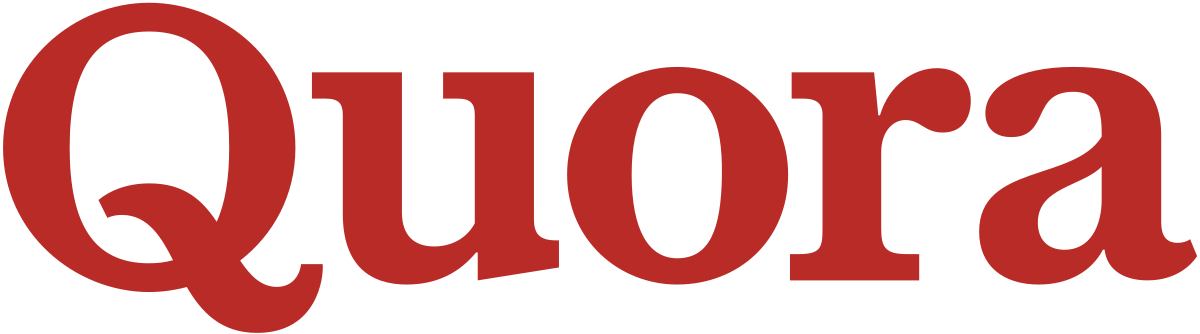

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

## Data Overview
- Data will be in a file Train.csv
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate
- Size of Train.csv - 60MB
- Number of rows in Train.csv = 404,290

## Data fields
- id - the id of a training set question pair
- qid1, qid2 - unique ids of each question (only available in train.csv)
- question1, question2 - the full text of each question
- is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

### IMPORTING LIBRARIES

In [2]:
import string
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization,Concatenate
from sklearn.model_selection import train_test_split

# To supress warnings
import warnings
warnings.filterwarnings('ignore')

print("All the libraries are imported....")

All the libraries are imported....


### MOUNT GOOGLE DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### LOAD DATA

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Quora Questions Pair/train.csv")
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
data[data['is_duplicate']==1].head()

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [5]:
test_data = pd.read_csv("/content/drive/MyDrive/Quora Questions Pair/test.csv")
test_data.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


* This is test data we'll calculate the similarity between these question pairs to get idea whether question are duplicate or not



### BASIC CHECKS

In [6]:
data.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


In [7]:
data.shape

(404290, 6)

* Total 404290 observation are present with 6 feature

In [8]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

* Total 6 feature is present including target veriable

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [10]:
data.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [11]:
data.describe(include='O')

,question1,question2
count,404289,404288
unique,290456,299174
top,How do I improve my English speaking?,How can you look at someone's private Instagra...
freq,50,120


* In Question1 total 290456 unique text are present and Question2 conatin 299174 unique text.

### EXPLOTARY DATA ANALYSIS

**Checking the balance of data**

In [12]:
# checking value counts
data.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [13]:
# Getting the percentage 
print(data.is_duplicate.value_counts()/data.is_duplicate.count()*100)

0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64


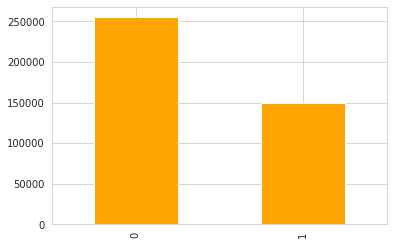

In [14]:
sns.set_style('whitegrid')
data.is_duplicate.value_counts().plot(kind='bar',color='orange')
plt.show()

* Here we need to balance the data

#### USED AUTMATED PANDAS PROFILING LIBRARY FOR EDA

In [ ]:
!pip install pandas-profiling

In [ ]:
from pandas_profiling import ProfileReport


# EDA using pandas profiling
profile = ProfileReport(pd.read_csv('train.csv'), explorative=True)

# Saving Result to a html file
profile.to_file('output.html')

#### REPEATED QUESTIONS

In [15]:
# Repeated questions
qid = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
print("Unique questions:",np.unique(qid).shape[0])
repeated = qid.value_counts()>1
print("Repeated questions:",repeated[repeated].shape[0])

Unique questions: 537933
Repeated questions: 111780


**Repeated questions histogram**

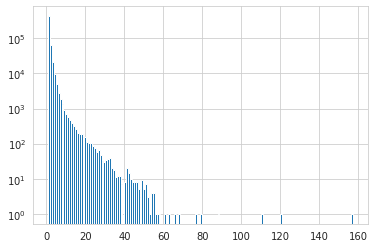

In [16]:
plt.hist(qid.value_counts().values, bins=160)
plt.yscale('log')
plt.show()

In [17]:
data.shape

(404290, 6)

### SPLIT DATA INTO TRAINING AND TESTING

In [18]:
X_train = data.iloc[:,:5].values
y_train = data.iloc[:,5:].values

In [19]:
# Testing data
X_testq1 = test_data.iloc[:400001,1:2].values
X_testq2 = test_data.iloc[:400001, 2:].values

In [21]:
X_testq1

array([['How does the Surface Pro himself 4 compare with iPad Pro?'],
       ['Should I have a hair transplant at age 24? How much would it cost?'],
       ['What but is the best way to send money from China to the US?'],
       ...,
       ['Where can I get very myself competitive price for wardrobe products in Sydney?'],
       ['Can I the differences between China and North Korea in socialism?'],
       ["If a 16 year-old has been convicted of 3 separate over violent crimes is it statistically certain he'll continue committing them at least until middle-age?"]],
      dtype=object)

In [22]:
X_testq2

array([['Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?'],
       ['How much cost does hair transplant require?'],
       ['What you send money to China?'],
       ...,
       ['Where can I get unbeatable prices way best service and quality for wardrobe products in Sydney?'],
       ["What's the difference in social system between China and North social?"],
       ['Software which can play 4 videos at different?']], dtype=object)

In [23]:
X_testq2.shape

(400001, 1)

### DATA PRE-PROCESSING

#### 1.CHECK MISSING VALUE

In [24]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

* In sample data their is no missing value is present

#### 2.CHECKING DUPLICATES

In [25]:
data.duplicated().sum()

0

### KERAS TEXT PREPROCESSING

In [26]:
"""  Keras' Tokenizer class to perform tokenization. 
In this project, I have tried out Keras' Tokenizer class and it also works pretty good

* MAX_NB_WORDS is a constant which indicates the maximum number of words that should be present. 
  Next, we fit out Tokenizer on all the questions in column 'question1' and 'question2'. """ 

MAX_NO_WORDS = 200000
tokenizer = Tokenizer(num_words=MAX_NO_WORDS)
tokenizer.fit_on_texts(list(data['question1'].values.astype(str)) + list(data['question2'].values.astype(str)))


**PADDING AND SEQUENCING**

In [27]:
""" Now, we convert all the questions in column 'question1' and 'question2', 
of both train and test set, into sequences, i.e, in the form of numbers since machine can only process numbers and not texts. 
We define the maximum length of each question and the questions which contain less than the required length are padded with 
zeros to make the length of the sentence equal to the mentioned length.


For example, maxlen = 5

sent1 = ['I', 'love','apples']

After sequencing,

sent1 = [1,2,3]

After padding,

sent1 = [1,2,3,0,0] """

X_train_q1 = tokenizer.texts_to_sequences(data['question1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen=30, padding='post')

X_train_q2 = tokenizer.texts_to_sequences(data['question2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen=30, padding='post')

In [54]:
# Ravel function is used to convert multidiamensional array into 1D array
X_test_q1 = tokenizer.texts_to_sequences(X_testq1.ravel())
X_test_q1 = pad_sequences(X_test_q1, maxlen=30, padding='post')

X_test_q2 = tokenizer.texts_to_sequences(X_testq2.astype(str).ravel())
X_test_q2 = pad_sequences(X_test_q2, maxlen=30, padding='post')

In [29]:
word_index = tokenizer.word_index
print(word_index)

{'the': 1, 'what': 2, 'is': 3, 'how': 4, 'i': 5, 'a': 6, 'to': 7, 'in': 8, 'do': 9, 'of': 10, 'are': 11, 'and': 12, 'can': 13, 'for': 14, 'you': 15, 'why': 16, 'my': 17, 'best': 18, 'it': 19, 'on': 20, 'does': 21, 'or': 22, 'which': 23, 'be': 24, 'if': 25, 'some': 26, 'have': 27, 'that': 28, 'with': 29, 'get': 30, 'should': 31, 'an': 32, 'from': 33, 'your': 34, 'india': 35, 'will': 36, 'when': 37, 'people': 38, 'like': 39, 'who': 40, 'at': 41, 'good': 42, 'would': 43, 'there': 44, 'as': 45, 'about': 46, 'not': 47, 'between': 48, 'one': 49, 'most': 50, 'we': 51, 'make': 52, 'way': 53, 'quora': 54, 'did': 55, 'where': 56, 'by': 57, 'any': 58, 'was': 59, 'me': 60, 'life': 61, 'so': 62, 'after': 63, 'time': 64, 'this': 65, 'they': 66, 'money': 67, 'know': 68, 'difference': 69, 'has': 70, 'learn': 71, 'am': 72, 'new': 73, 'use': 74, "what's": 75, 'much': 76, 'their': 77, 'think': 78, 'many': 79, 'work': 80, 'all': 81, 'indian': 82, 'someone': 83, 'than': 84, 'more': 85, 'ever': 86, 'find': 

In [30]:
# Length of mapping of words to integer
print(len(word_index))

95596


### Loading Glove word embedding
GloVe (Global Vectors) is a model for distributed representations. The model is an unsupervised learning algorithm for obtaining vector representation for words. This is taken care of by mapping words into meaningful space where the distance between the words is related to semantic similarity. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [31]:
embedding_index = {}
with open(r"/content/drive/MyDrive/Quora Questions Pair/glove.6B.200d.txt",'r',encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_index[word] = vectors
    f.close()

In [32]:
embedding_matrix = np.random.random((len(word_index)+1,200))
for word, i in word_index.items():
    embedding_vector = word_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### LSTM (Long Short Term Memory)
Long Short Term Memory is a variation of RNN which is used to eliminate the Vanishing Gradients Problem. It is much more powerful and complex than other variations of RNN, i.e., GRU.

In [33]:
# Model for Question1
# Create sequential model
model_q1 = tf.keras.Sequential()
model_q1.add(Embedding(input_dim=len(word_index)+1,
                                 output_dim=200,
                                 weights=[embedding_matrix],
                                 input_length=30))
model_q1.add(LSTM(128, activation='tanh', return_sequences=True))
model_q1.add(Dropout(0.2))
model_q1.add(LSTM(128, return_sequences=True))
model_q1.add(LSTM(128))
model_q1.add(Dense(60, activation='tanh'))
model_q1.add(Dense(2, activation='sigmoid'))


In [34]:
# Model for Question2
model_q2 = tf.keras.Sequential()
model_q2.add(Embedding(input_dim=len(word_index)+1,
                      output_dim=200,
                      weights=[embedding_matrix],
                      input_length=30))
model_q2.add(LSTM(128, activation='tanh', return_sequences=True))
model_q2.add(Dropout(0.2))
model_q2.add(LSTM(128, return_sequences=True))
model_q2.add(LSTM(128))
model_q2.add(Dense(60, activation='tanh'))
model_q2.add(Dense(2, activation='sigmoid'))

In [36]:
# Merging output of the two model i.e(model_q1, model_q2)
from tensorflow.keras.layers import Multiply

mergeout = Multiply()([model_q1.output, model_q2.output])

mergeout = Flatten()(mergeout)
mergeout = Dense(100, activation='relu')(mergeout)
mergeout = Dropout(0.2)(mergeout)
mergeout = Dense(50, activation='relu')(mergeout)
mergeout = Dropout(0.2)(mergeout)
mergeout = Dense(2, activation='sigmoid')(mergeout)

In [37]:
new_model = Model([model_q1.input, model_q2.input], mergeout)

### VISUALISE MODEL

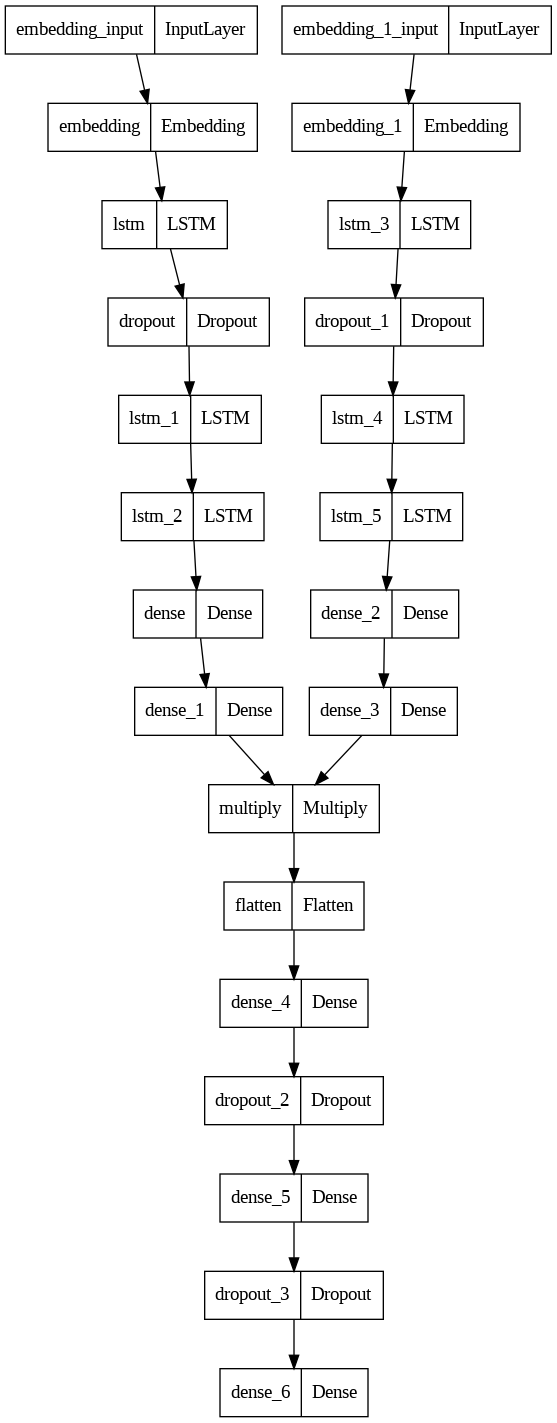

In [59]:
from tensorflow.keras.utils import plot_model
plot_model(new_model, to_file='model.png')


### COMPILE AND TRAIN MODEL

In [42]:
# Compile model
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit model for training
hist = new_model.fit([X_train_q1, X_train_q2], y_train, batch_size=2000, epochs=150)

Epoch 1/150
203/203 [==============================] - 38s 147ms/step - loss: 0.5486 - accuracy: 0.6956
Epoch 2/150
203/203 [==============================] - 30s 149ms/step - loss: 0.5476 - accuracy: 0.6970
Epoch 3/150
203/203 [==============================] - 31s 151ms/step - loss: 0.5462 - accuracy: 0.6981
Epoch 4/150
203/203 [==============================] - 31s 152ms/step - loss: 0.5463 - accuracy: 0.6972
Epoch 5/150
203/203 [==============================] - 31s 152ms/step - loss: 0.5450 - accuracy: 0.6991
Epoch 6/150
203/203 [==============================] - 31s 152ms/step - loss: 0.5432 - accuracy: 0.6997
Epoch 7/150
203/203 [==============================] - 31s 153ms/step - loss: 0.5424 - accuracy: 0.7005
Epoch 8/150
203/203 [==============================] - 31s 153ms/step - loss: 0.5432 - accuracy: 0.6998
Epoch 9/150
203/203 [==============================] - 31s 153ms/step - loss: 0.5396 - accuracy: 0.7035
Epoch 10/150
203/203 [==============================] - 31s 153m

### PLOT LOSS AND ACCURACY

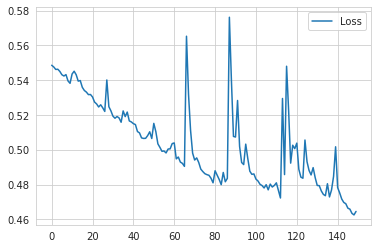

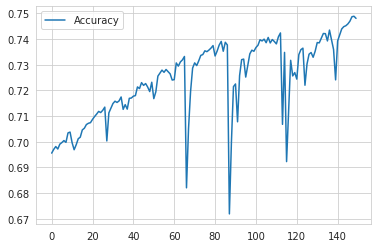

In [43]:
plt.plot(hist.history['loss'], label='Loss')
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()

### MODEL SAVING

In [44]:
new_model.save('paraphrases_detection.h5')

### PREDICTION USING PREPROCESS TEST DATA

In [55]:
y_pred = new_model.predict([X_test_q1, X_test_q2])

12501/12501 [==============================] - 116s 9ms/step


In [57]:
np.argmax(y_pred[:100],axis=-1)

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])